In [160]:
import sys
import os

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import choice
from string import ascii_lowercase

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Input, concatenate, Reshape, Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.backend.tensorflow_backend import set_session 
from keras.utils import np_utils
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn import metrics


#root
absPath = '/home/angela/padding_uniprot/'
sys.path.insert(0, absPath)

from src.Target import Target

In [16]:
random.seed(8)

In [111]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf.set_random_seed(22)
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 1

In [6]:
#list of amino acids
list_aas = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 
            'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
#length of sequences
m = 500
#sample size (number of sequences)
n=20000
#creating random sequences
rdm_seqs = []
for i in range(n):
    rdm_seqs.append("".join(choice(list_aas) for j in range(m)))

In [10]:
print("There are", len(rdm_seqs), "sequences")
print("Example of first sequence: ", rdm_seqs[0])
print("Example of second sequence: ", rdm_seqs[1])

There are 20000 sequences
Example of first sequence:  LFFPPVOYMUUXDTCQQMAVCXIKTLSWISPWGGKLEWMOQLBZEWSKKAWHLEHHUVIPXZCIZXFHDIPIGWQLIWWCHAZTLRNTLFEIVOIDPARYHIHSATBXZRUEEKTETXAOKNCETBMTGNUSEMQTKRMIPGAKKEIUXAEWSLOPIEMPNCWVNQHUSYVNEXANBDILFHWYCNSSYXKKHGFYAPBFTZZIFUOSDUBTBOYBHATQXRSNMIQXBBIHFDYHLBHAOWHDFUXBWNZTCHQYBXTTLDTEWTSVFLXEYBZGOVAXIFMLBCXXGUPQRNUCDEZBIBEZVMTITILDSWAGCODSLYIKXCMZHCGEDKSHXAIQOVSOWQYWLEYCARZXUFWENVTWZLKEVPIBOBUZOQWXWBHUZBTNFRXVTLPBFZYVIKVSPWCKOTZGDRWPPUYFQXQVPHATTYAEXFISFMKYBNNGNPWBEVHIYECAQFYZRMIDMSXXQXFAASETIQRWDEOCAELXNWTODNKCELLO
Example of second sequence:  QUFEGRNGMDARHHBGPMSIQNYFXQAZXBLMSFBPKSUTPUPCNSWNTLDVUPGWYCOLPHNNBIFAWLMARNHVDPRFZPUDMAHHUGAOOXWIOQBTWXXZPQBNZZUBSVWZXHOKTUYSUIGBQOHGWCFYOBQCDBXWYVIMTERBWBEETMMMMDTKKXAEHMRHVQEWXNGCDIVCBDHMGNZIXHKSMLQBZQLMWGTDQBUNHMISYKELWBKOZCXLSFNQTECHNXXCLTGPYFAMMPVYERMQRMIQTMGWPAZNNTICUOXPGSBDGFVTRTFPMXVKQWXWPTGCANVMWHRGVTCUNNGCNOICYOHDTXBWQQMERZQYQVVIZHOZMFQIZIHDKWMCOGCSAILETVQMYNOZXPPOGFXYVOZCKXAMQEDCFIAUSGCQITMHZBETYQLTKRPM

In [43]:
#In half of them we will introduce a very obvious motif
syn_motif = 'A'*50
#we take the first half of the sequences...
seqs2motif = rdm_seqs[:int(n/2)]
#...and we add the motif in a random position
motif_seqs = []
for i in seqs2motif:
    pos = random.randint(0, m-len(syn_motif)-1)
    motif_seqs.append(i[:pos-1] +syn_motif + i[pos+(len(syn_motif)-1):])

In [64]:
#creating a dataframe for data
df_seqs = pd.DataFrame(columns=['sequence', 'label'])
df_seqs2 = pd.DataFrame(columns=['sequence', 'label'])

In [65]:
#adding sequences with motifs and labelling them as "2.0" (for BigDL)
df_seqs['sequence'] = motif_seqs
df_seqs['label'] = '2.0'

In [67]:
#adding sequences with no motifs and labelling them as "1.0" (for BigDL)
df_seqs2['sequence'] = rdm_seqs[int(n/2):]
df_seqs2['label'] = '1.0'

In [68]:
#joining both dataframes
df_seqs = pd.concat([df_seqs, df_seqs2])

In [69]:
df_seqs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Data columns (total 2 columns):
sequence    20000 non-null object
label       20000 non-null object
dtypes: object(2)
memory usage: 468.8+ KB


In [70]:
#shuffling rows
df_seqs = df_seqs.sample(frac=1).reset_index(drop=True)

In [72]:
df_seqs.head()

,sequence,label
0,CGDCODAOLRPUZXSWDPRGVXAYTQFWBWATUTCOGSRNZGOMAZ...,1.0
1,MMNYHQWANCSPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,2.0
2,LERVLFPPWCYCWBCLALBHVFNDKKUOCLOREGOZNFZQRYTGFV...,1.0
3,MUILREERQPZVDNNUCKOLKTIYZAYYBUXCMAXLLEAFVUHDDP...,1.0
4,EFPKKDZBAPINAQIYFISIULXLWHARFGCIARSUYECLHKFYVB...,1.0


In [90]:
df_seqs['label'] = df_seqs['label'].astype(float)

In [91]:
df_seqs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
sequence    20000 non-null object
label       20000 non-null float64
dtypes: float64(1), object(1)
memory usage: 312.6+ KB


In [73]:
df_seqs.to_csv('/home/angela/padding_uniprot/data/syn_sequences.csv', 
              header=False, index=False)

# Training model

In [139]:
#Defining Adam optimizer
epochss = 100
#learning_rate = 5e-6
#learning_rate = 0.01
#decay_rate = learning_rate/epochss
#adamm = Adam(lr=learning_rate, beta_1=0.1, beta_2=0.001, epsilon=1e-08, decay=decay_rate)
adamm = Adam()

In [140]:
# PARAMETERS
n_hid = 256 #number of hidden neurons
n_class = 2 #number of classes to output
drop_per = 0.2 #Input dropout 
drop_hid = 0.5 #hidden neurons dropout
n_filt = 10 # number of filter in the first convolutional layer
n_filt2 = 64
lng_inp = m #length of the input, which is the max length of targets
dict_size = len(list_aas)

#### CNN  filters ####
f_size_a = 1
f_size_b = 3
f_size_c = 5
f_size_d = 9
f_size_e = 15
f_size_f = 21

In [141]:
input_seq = Input(shape=(lng_inp, dict_size), dtype='float32')
dropout_seq = Dropout(drop_per)(input_seq)

#Second convolutional layer
conv_seq = Conv1D(filters=n_filt2, padding='same', strides=1, kernel_size=f_size_b, activation='relu')(dropout_seq)

#Another dropout
dropout_seq2 = Dropout(drop_hid)(conv_seq)

#Bidirectional LSTM
#bilstm_seq = Bidirectional(LSTM(n_hid, dropout=drop_hid, recurrent_dropout=drop_hid, activation='tanh'), merge_mode='concat')(dropout_seq2)
reshape_seq = Flatten()(dropout_seq2)

#Dense
dense_seq1 = Dense(n_hid*2, activation='relu', input_dim=n_hid)(reshape_seq)
dropout_seq3 = Dropout(drop_hid)(dense_seq1)

main_dense = Dense(n_class, activation='softmax')(dropout_seq3)

In [142]:
#Build and compile model
model = Model(inputs=[input_seq], outputs=[main_dense])
model.compile(loss='categorical_crossentropy', optimizer = adamm, metrics=['accuracy'])

In [143]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500, 25)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 500, 25)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 64)           4864      
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               16384512  
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
__________

In [144]:
#taking data from dataframe
seqs = df_seqs['sequence'].values
labels = df_seqs['label'].values

labels_replaced = [0.0 if i == 1.0 else 1.0 for i in labels]

In [145]:
print(labels[:10])
print(labels_replaced[:10])

[ 1.  2.  1.  1.  1.  2.  1.  1.  2.  1.]
[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]


In [146]:
#Getting amino acids dictionary
nums = list(range(0, len(list_aas)))
aa_to_int = dict(zip(list_aas, nums))

In [147]:
#Processing data
def target_to_int(seq, dictionary):
    """Translate a sequence of amino acids to a list of integers, given a dictionary"""
    target_int = []
    aminoacids = list(seq)
    for i in aminoacids:
        target_int.append(dictionary[i])
    return target_int
    
def int_to_onehot(x_int, num_classes):
    """Translate a list of integers to one hot encoding"""
    onehot = np_utils.to_categorical(x_int, num_classes=num_classes)
    return onehot

# 2nd: we convert amino acid sequences to integer sequences
seqs_int = [target_to_int(x, aa_to_int) for x in seqs]
seqs_int_array = sequence.pad_sequences(sequences=seqs_int, maxlen=m)

# 3rd: we convert integer sequences to one hot
seqs_onehot = int_to_onehot(list(seqs_int_array), len(aa_to_int))
seqs_onehot.shape

(20000, 500, 25)

In [148]:
#Encode labels

labels_onehot = [np_utils.to_categorical(x, num_classes=2) for x in labels_replaced]

In [149]:
training_split = 0.8
val_split = 0.5
indices = list(np.arange(len(seqs_onehot)))

x_train, x_valtest, y_train, y_valtest, idx_train, idx_valtest = train_test_split(
    seqs_onehot, labels_onehot, indices, test_size=(1-training_split))

x_val, x_test, y_val, y_test, idx_val, idx_test = train_test_split(
    x_valtest, y_valtest, idx_valtest, test_size=0.5)

In [150]:
history = model.fit(x=x_train, y=np.asarray(y_train), 
                    validation_data=(x_val, np.asarray(y_val)), 
                    epochs=epochss, verbose=1)

Train on 16000 samples, validate on 2000 samples
Epoch 1/100
16000/16000 [==============================] - 26s 2ms/step - loss: 0.0867 - acc: 0.9762 - val_loss: 1.0573e-04 - val_acc: 1.0000
Epoch 2/100
16000/16000 [==============================] - 25s 2ms/step - loss: 4.8661e-04 - acc: 1.0000 - val_loss: 2.6441e-05 - val_acc: 1.0000
Epoch 3/100
16000/16000 [==============================] - 25s 2ms/step - loss: 1.7698e-04 - acc: 1.0000 - val_loss: 5.5479e-06 - val_acc: 1.0000
Epoch 4/100
16000/16000 [==============================] - 17s 1ms/step - loss: 8.0733e-04 - acc: 0.9999 - val_loss: 1.2762e-05 - val_acc: 1.0000
Epoch 5/100
16000/16000 [==============================] - 14s 891us/step - loss: 1.0714e-04 - acc: 1.0000 - val_loss: 1.3915e-06 - val_acc: 1.0000
Epoch 6/100
16000/16000 [==============================] - 24s 2ms/step - loss: 4.3468e-05 - acc: 1.0000 - val_loss: 4.4990e-07 - val_acc: 1.0000
Epoch 7/100
16000/16000 [==============================] - 25s 2ms/step - los

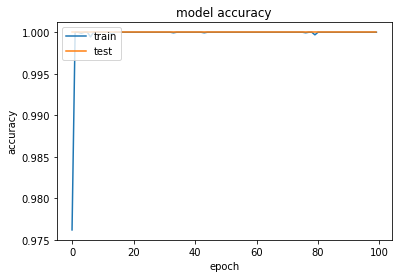

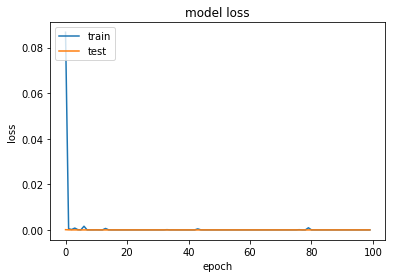

In [154]:
history = history.history

plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()   

In [156]:
y_predprob = model.predict(x_test)
y_pred = y_predprob.argmax(axis=-1)
y_test_scalar = np.asarray(y_test).argmax(axis=-1)
y_prob = y_predprob[:,1]

In [157]:
from collections import Counter
Counter(y_pred)

Counter({0: 1012, 1: 988})

In [158]:
y_predprob[:10]

array([[  1.00000000e+00,   1.05198597e-12],
       [  1.36373876e-38,   1.00000000e+00],
       [  1.00000000e+00,   1.11907738e-12],
       [  0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   5.32107670e-13],
       [  0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   7.30977887e-13],
       [  0.00000000e+00,   1.00000000e+00]], dtype=float32)

In [161]:
#model report
print ("\nModel Report")
print ("Accuracy (test set): %.4g" % metrics.accuracy_score(y_test_scalar, y_pred))
print("Confusion matrix:")
print (metrics.confusion_matrix(y_test_scalar, y_pred))
print("Detailed classification report:")
print (metrics.classification_report(y_test_scalar, y_pred))


Model Report
Accuracy (test set): 1
Confusion matrix:
[[1012    0]
 [   0  988]]
Detailed classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1012
          1       1.00      1.00      1.00       988

avg / total       1.00      1.00      1.00      2000

